# Executive Summary

The goal of E-FORCE ML is to predict, as far out as is tractable, energy consumption patterns for a typical home in suburban France. We have access to data for one household in a suburb of Paris, provided by UCIrvine. In this report, we will describe our workflow and the results of performing exploratory data analysis (EDA), outlier detection, and nested cross-validation on the data. The motivation of this investigation is to make more efficient the logistics of grid planning and resource allocation by identifying the variables driving changes in consumption and modeling this change into the near future. Through our EDA we uncovered the seasonal trends in energy consumption, represented by global active power, at varying levels of granularity. For instance, at the monthly level we can observe that the household used much more energy in winter than in summer, while at the daily level we can observe that more power was used in evenings than in mornings. We determined that daily summaries were most conducive to building models with high predictive power. We then performed outlier detection using ARIMA (with and without residuals) and STL decomposition. We also leveraged FB Prophet, a tool specially designed for time series outlier detection. Each method found a similar set of outliers, so we were able to confidently remove those before training our models. Lastly, we performed nested cross-validation to determine the optimal model architecture, parameters, and hyper-parameters, evaluating each on multiple criteria including Mean Absolute (Percentage) Error, Akaike Information Criterion, and the Durbin-Watson statistic. We chose to focus on 3 possible architectures -- SARIMAX, SVR, and LSTM -- all of which are common choices for modeling time series data. SARIMAX is the most explainable model, followed closely by SVR, while LSTM is a deep architecture that is a powerful predictor, but not as interpretable. The nested cross-validation returned SVR as the best option, but all three perform quite well when optimal (hyper)parameters are chosen. Ultimately, these analyses and models may be used to inform decisions about how to allocate energy resources in the region -- concretely, when to send how much power to which substations, and whether or not to expand their service area or increase capacity in some areas. Using this model, the local government/utility company can better service the residents and keep their own costs low, making people happier and enabling other funds/resources to go towards other ventures.

## Data Source/Description

The data can be found at [https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption). This dataset tracks minute-by-minute energy consumption data for one house in southern suburban Paris, in the form of multivariate time series. It contains information on both the overall energy used in the house and submeter data for several locations within the house, giving us a fine-grained view of the consumption patterns. With this, we can predict year-to-year trends and seasonal variability. While the data is only for a single household, we may operate under the assumption that houses in one neighborhood will all have consumption patterns similar on average to those of our chosen representative. This is due to a high probability of one particular culture/lifestyle dominating the neighborhood. Hence, the highly rich data in the UCI asset will grant us lots of predictive power over the region.

## Column Names and Descriptions

1. **Global_active_power**: 
   - The total active power consumed by the household (in kilowatts).

2. **Global_reactive_power**: 
   - The total reactive power consumed by the household (in kilowatts).

3. **Voltage**: 
   - The average voltage (in volts) supplied to the household.

4. **Global_intensity**: 
   - The average current intensity (in amperes) drawn by the household.

5. **Sub_metering_1**: 
   - Energy sub-metering No. 1 (in watt-hours): corresponds to the kitchen (e.g., dishwasher, oven, microwave).

6. **Sub_metering_2**: 
   - Energy sub-metering No. 2 (in watt-hours): corresponds to the laundry room (e.g., washing machine, tumble dryer, refrigerator, light).

7. **Sub_metering_3**: 
   - Energy sub-metering No. 3 (in watt-hours): corresponds to the climate control systems (e.g., air conditioning, electric water heater).

8. **non_submetered**: 
   - Energy consumption not accounted for by the submeters (calculated as: Global_active_power * 1000 / 60 - sum of all submeters).

9. **DayCount**: 
   - The day of the year (1 to 365 or 366), starting from January 1st.

10. **DayOfWeek**: 
    - The day of the week (integer: Monday=0 to Sunday=6).

11. **IsWeekend**: 
    - Binary flag indicating if the day is a weekend (1 for Saturday and Sunday, 0 otherwise).

12. **Month**: 
    - The month of the year (integer: 1 for January to 12 for December).

13. **AvgTemperature**: 
    - The average daily temperature (in degrees Celsius).

14. **MinTemperature**: 
    - The minimum daily temperature (in degrees Celsius).

15. **MaxTemperature**: 
    - The maximum daily temperature (in degrees Celsius).

16. **Precipitation**: 
    - The total daily precipitation (in millimeters).

17. **tsun**: 
    - The total daily sunshine duration (in hours). Currently contains all zero values; may need verification.

## Notes:
- The dataset includes features derived from both energy consumption and weather data.
- Missing values in weather data have been handled using feature-specific imputation strategies.
- Temporal features (`DayCount`, `DayOfWeek`, `IsWeekend`, `Month`) were generated to assist in time-series analysis.


## Data Pre-Processing Steps

In this project, we are working with a dataset that measures household electricity consumption and environmental conditions. The dataset includes the following columns:

- **Global Active Power:** The primary target variable, representing the total active power consumed by the household.
- **Global Reactive Power, Voltage, Global Intensity:** Initially provided but dropped due to high correlation and minimal additional predictive value.
- **Sub_metering_1, Sub_metering_2, Sub_metering_3, Non_submetered:** These represent the disaggregated energy consumption of different household sub-metering points. We apply a one-day lag to these variables so that the model uses "yesterday’s" sub-metered values to predict "today’s" Global Active Power. This shift prevents trivial reverse-engineering of the target.
- **DayCount, DayOfWeek, IsWeekend, Month:** Temporal features indicating the day number, day of the week, whether it’s a weekend, and the month. These features remain at time `t` because they describe current conditions and do not directly leak future information.
- **AvgTemperature, MinTemperature, MaxTemperature, Precipitation, tsun (Total Sunshine Hours):** Environmental and weather-related features. These remain time-aligned with the target (no lag) since they represent current-day conditions.

### Handling Anomalies in the Target Variable

To identify and handle anomalies (unusual spikes or drops) in Global Active Power, we use a method based on the residuals from a Facebook Prophet model:

1. **Prophet Fitting:**  
   We fit a Facebook Prophet model to the Global Active Power time series. Prophet captures trends and seasonality, providing a predicted value for each time point.

2. **Residual Analysis:**  
   After obtaining predictions from the Prophet model, we compute residuals (actual minus predicted). Residuals represent how much the actual value deviates from the model’s expectation.

3. **Anomaly Threshold:**  
   We define anomalies as points where the residual’s absolute value exceeds 2.5 times the residual’s standard deviation. This threshold is a heuristic that flags significantly large deviations.

4. **Anomaly Imputation:**  
   For identified anomalies, we replace the Global Active Power value with the Prophet-predicted value. This imputation smooths out extreme outliers.

### Comparison with STL Decomposition

We found that the Prophet-based anomaly detection yields similar results to an STL decomposition approach, which decomposes the series into seasonal, trend, and remainder components. Since both methods highlight similar anomalies, using the Prophet-based approach is consistent and straightforward. As it auto detects seasonality and trends, it is more robust to changes in the data compared to STL decomposition.

### Final Cleaned Dataset

After anomaly detection and imputation, as well as applying the one-day lag to submetering variables, we produce a cleaned and processed dataset. This dataset is then used for nested cross-validation, model selection, hyperparameter tuning, and ultimately forecasting the daily Global Active Power consumption.


In [1]:
# Block 1: Import Libraries and Load Data

# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Cross-Validation
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler

# Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Statistical Metrics
from statsmodels.tools.eval_measures import aic
from statsmodels.stats.stattools import durbin_watson

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load your preprocessed data
daily_data = pd.read_csv('data_without_anomalies_prophet.csv', parse_dates=['Date'], index_col='Date')

# Ensure data is sorted by date
daily_data.sort_index(inplace=True)


In [85]:
print(daily_data.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'non_submetered', 'DayCount', 'DayOfWeek',
       'IsWeekend', 'Month', 'AvgTemperature', 'MinTemperature',
       'MaxTemperature', 'Precipitation', 'tsun'],
      dtype='object')


In [86]:
# Block 2: Prepare Data for Modeling

# Define the target variable
y = daily_data['Global_active_power']

# Define the full feature set
X = daily_data.drop(['Global_active_power'], axis=1)
# Drop columns with high correlation to Global_active_power
X = X.drop(['Global_reactive_power', 'Voltage', 'Global_intensity', 'tsun'], axis=1)

# Apply a one-day lag to submetered variables to prevent trivial reverse-engineering of the target
X['Sub_metering_1'] = X['Sub_metering_1'].shift(1)
X['Sub_metering_2'] = X['Sub_metering_2'].shift(1)
X['Sub_metering_3'] = X['Sub_metering_3'].shift(1)
X['non_submetered'] = X['non_submetered'].shift(1)

# Drop rows that now contain NaN due to lagging
X = X.dropna()

# Align y with the updated X index
y = y.loc[X.index]
# Remove the last 200 days for independent testing
X_train = X.iloc[:-200]
y_train = y.iloc[:-200]

X_holdout = X.iloc[-200:]  # Independent test set (final 200 days)
y_holdout = y.iloc[-200:]



In [87]:
# Block 3: Define Evaluation Metrics

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

def evaluate_model(y_true, y_pred, model_fit=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Additional metrics for SARIMAX
    if model_fit is not None:
        # Akaike Information Criterion
        metrics['AIC'] = model_fit.aic
        # Durbin-Watson statistic
        residuals = y_true - y_pred
        metrics['Durbin_Watson'] = durbin_watson(residuals)
    return metrics


In [88]:
# Block 4: Define Cross-Validation Strategy

# Define the number of splits (adjust as needed)
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [89]:

# Block 5: Define Random Search Grids and Feature Subsets

# Define hyperparameter distributions for random search
from scipy.stats import randint, uniform, loguniform

# SARIMAX hyperparameter distributions, this is primarily from empirical observations
sarimax_param_dist = {
    'order': [(p, 0, q) for p in range(0, 3) for q in range(0, 3)],
    'seasonal_order': [(P, 0, Q, 7) for P in range(0, 2) for Q in range(0, 2)]
}


svr_param_dist = {
    'C': loguniform(0.1, 50),                # Wider range with logarithmic scaling
    'epsilon': uniform(0.01, 0.75),          # Slightly wider tolerance for error
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Additional kernel options
    'lag_binary': ['00000000', '10000000', '11100000', '11111111', '11001100'],  # More lag configurations
}

# LSTM hyperparameter distributions
lstm_param_dist = {
    'hidden_size': randint(32, 256),           # Expanded range for hidden units
    'num_layers': randint(1, 4),               # Allowing up to 4 layers
    'sequence_length': randint(7, 30),         # Sequence length between 7 and 30 days
    'dropout': uniform(0.1, 0.5),              # Dropout rate between 0.1 and 0.5
    'learning_rate': loguniform(0.001, 0.01)  # Learning rate between 0.001 and 0.01
}

# Define feature subsets
feature_subsets = [
    # Subset 1: Weather variables
    ['AvgTemperature', 'Precipitation', 'non_submetered','DayCount', 'DayOfWeek' ],
    # Subset 2: Submetering data
    ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'non_submetered'],
    # Subset 4: All features
    #X.columns.tolist(),
    # Subset 5: Custom feature subset
    ['AvgTemperature', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'DayCount', 'DayOfWeek']
] 



# Model Function Definitions

## Modeling Approach

Our approach begins with feature selection via a correlation heatmap, F-score, and a random forest permutation importance method. Variables too highly correlated, such as global reactive power and global intensity, are to be discarded as they are likely to cause overfitting, while variables with no correlation, such as precipitation, are discarded since they add complexity but do not contribute at all to predictive power. The F-score and permutation importance are more sophisticated and in our case confirm the correlation heatmap's suggested feature ranking.

We chose to train three model architectures, SARIMAX, SVR, and LSTM. SARIMAX is a statistical model that leverages seasonality, autoregression, integration, moving averages, and exogenous variables to fit a model and extrapolate into the future. Hence, it provides a descriptive analysis (What is the seasonality, is the series stationary, how does the moving average behave over time, etc) along with a predictive analysis. SVR, or Support Vector Regression, is another relatively interpretable model for time series analysis. It excels at capturing relationships in non-linear data and is inherently robust to noise. Our data is not that complex, but the model is nonetheless likely a good choice (as we will see, it ends up performing the best out of all three). This model is particularly useful for feature engineering and other descriptive tasks as well as its powerful predictive ability. LSTM, or long short term memory, is a deep learning architecture, specifically a recurrent neural network. It requires minimal preprocessing compared to the other two methods and captures complexity well like SVR, but is less interpretable and may be prone to overfitting. Hence, its utility is primarily in predictive or prescriptive analytics rather than descriptive.

We perform a three-loop nested cross validation on the three models. The outermost loop iterates over possible features subsets. The first inner loop chooses the model family (and by extension associated hyperparameters, e.g. number of neurons for LSTM). The innermost loop performs time series k-fold cross validation with k=5. For all three models we use Mean Absolute Error, Mean Absolute Percentage Error, and Root Mean Squared Error. For each SARIMAX model, we also evaluate the Akaike Information Criterion and Durbin-Watson statistic.

Our workflow begins with comprehensive data preprocessing. The original dataset, obtained from a UCI repository, provides minute-level household electricity consumption along with environmental and temporal attributes. Our variables include:

- **Target Variable:** Global Active Power.
- **Submetered Variables:** Sub_metering_1, Sub_metering_2, Sub_metering_3, and non_submetered (summarize different household components).
- **Temporal Features:** DayCount, DayOfWeek, IsWeekend, Month, capturing daily progression and weekly/monthly patterns.
- **Environmental Features:** AvgTemperature, MinTemperature, MaxTemperature, Precipitation, and tsun (total sunshine hours).

We first remove strongly correlated variables (Global Reactive Power, Voltage, Global Intensity) to avoid redundancy and overfitting, and drop irrelevant features (like tsun if found non-informative) based on correlation heatmaps, F-scores, and random forest permutation importance. This ensures a lean feature set that balances complexity and predictive utility.

To address anomalies in Global Active Power, we fit a **Facebook Prophet** model to detect and impute outliers. We consider residuals exceeding 2.5 standard deviations as anomalies and replace those target values with Prophet’s predictions. This approach, similar in effect to an STL decomposition-based anomaly detection, cleans the target series without losing meaningful structure.

Next, we introduce a critical transformation: **lagging submetered variables by one day**. By shifting Sub_metering_1, Sub_metering_2, Sub_metering_3, and non_submetered, we ensure that “yesterday’s” consumption patterns inform “today’s” Global Active Power forecast, preventing trivial data leakage that would otherwise cause extreme overfitting.

These lagging and anomaly-imputation steps are applied before model training and cross-validation. After lagging and cleaning, we split the data into a training set and a final 200-day holdout set for independent evaluation.

### Feature Subsets and Model Selection

Our analysis tests multiple **feature subsets** to identify the combination of variables that yields robust, accurate forecasts. For example:
- A subset focusing on weather-related variables and a few select temporal/consumption features.
- A subset emphasizing submetering data (lagged as described).
- A larger subset incorporating nearly all features.
- A custom combination balancing weather, submetering, and temporal indicators.

These subsets are evaluated systematically to determine which set of features best supports the forecasting task.

### Three Model Architectures

1. **SARIMAX (Seasonal ARIMA with Exogenous Variables):**  
   SARIMAX provides both descriptive and predictive power. It models trends, seasonality, and exogenous inputs. We treat seasonality parameters (P, Q, seasonal period) as hyperparameters to be tuned. SARIMAX can reveal whether the series is stationary, which seasonal periods matter, and how external features shape the forecast. We track not only MAE, RMSE, and MAPE but also the Akaike Information Criterion (AIC) and Durbin-Watson statistic for residual diagnostics, ensuring well-specified and non-autocorrelated residuals.

2. **SVR (Support Vector Regression):**  
   SVR handles non-linearities and is less prone to overfitting than simpler linear models. We incorporate a binary “lag_binary” string parameter to decide which lagged versions of the target to include as features, enabling flexible modeling of temporal dynamics. SVR hyperparameters (C, epsilon, kernel) are sampled from distributions to explore a broad range of configurations. Although not inherently “sequence-based,” SVR leverages lagged variables and chosen features to capture temporal dependencies effectively.

3. **LSTM (Long Short-Term Memory):**  
   LSTM is a recurrent neural network architecture suited for time series. It can model complex patterns with minimal manual feature engineering. We randomize hidden_size, num_layers, sequence_length, dropout, and learning_rate, allowing the model to learn intricate dependencies. While LSTMs can overfit if patterns are not strong or the dataset is small, careful cross-validation and hyperparameter search help mitigate this. The LSTM’s strength is primarily predictive; it’s less interpretable than SARIMAX or SVR, but can excel if genuine temporal patterns exist.

### Nested Cross-Validation with Random Search

Our evaluation uses a **three-loop nested cross-validation** scheme:

- **Outer Loop:** Iterates over predefined feature subsets, testing how different variable combinations influence model performance.
- **Middle Loop:** Chooses the model family (SARIMAX, SVR, LSTM) and its associated hyperparameters. We rely on random search (via `ParameterSampler`) to sample from distributions (e.g., `loguniform` for SVR’s C, uniform for dropout in LSTM, discrete grids for SARIMAX seasonal orders).
- **Inner Loop (Time-Series Split):** Employs time series k-fold cross-validation (k=5) to robustly estimate model performance under temporal ordering constraints. In each fold, we scale features and target inside the fold to avoid leakage. The model is trained on past data and tested on future segments, ensuring honest performance estimation.

This deeply integrated approach—feature subset testing, model family comparison, random hyperparameter sampling, and time-series validation—yields a rich performance landscape. While complex, it ensures no stone is left unturned. Each model-feature-parameter combination is evaluated using MAE, MAPE, and RMSE, and for SARIMAX, AIC and Durbin-Watson further guide model adequacy.

### Balancing Complexity and Interpretability

This pipeline, though intricate, allows us to:

- Identify which features and transformations (like lagging) genuinely reduce overfitting and improve forecast realism.
- Determine which model family can best handle the given data structure (SVR often emerges as a top performer, but SARIMAX’s interpretability and LSTM’s flexibility also add value).
- Understand the trade-offs between complexity and stability, potentially using a two-step process: first selecting model and features with this complex CV, then performing more controlled hyperparameter tuning (like grid search) on the chosen model and feature subset.

In summary, our modeling approach integrates advanced anomaly handling, careful feature engineering (especially lagging submetered variables), three diverse model architectures, and a nested cross-validation with random hyperparameter search. While complex, this approach ensures a thorough exploration of the solution space, guiding us toward a robust and interpretable final forecasting model.



### 1. SARIMAX
The `train_sarimax` function trains and evaluates a Seasonal ARIMA (SARIMAX) model:
- **Inputs**:
  - `y_train` and `y_test`: Target variable for training and testing.
  - `X_train` and `X_test`: Exogenous variables (features).
  - `param_list`: List of SARIMAX hyperparameters (`order` and `seasonal_order`).
  - `scaler_y`: Scaler used to inverse-transform the target variable for evaluation.
- **Outputs**:
  - A list of dictionaries containing hyperparameters (`Params`) and evaluation metrics (`Metrics`).
- **Metrics**:
  - MAE, RMSE, MAPE, AIC, and Durbin-Watson.

### 2. SVR (Support Vector Regression)
The `train_svr` function trains and evaluates an SVR model:
- **Inputs**:
  - `y_train` and `y_test`: Scaled target variables.
  - `X_train` and `X_test`: Scaled features.
  - `param_list`: List of SVR hyperparameters (`C`, `epsilon`, and `kernel`).
  - `scaler_y`: Scaler used to inverse-transform the target variable for evaluation.
- **Outputs**:
  - A list of dictionaries containing hyperparameters (`Params`) and evaluation metrics (`Metrics`).
- **Metrics**:
  - MAE, RMSE, and MAPE.

### 3. LSTM (Long Short-Term Memory)
The `train_lstm` function trains and evaluates an LSTM model:
- **Inputs**:
  - `y_train` and `y_test`: Scaled target variables.
  - `X_train` and `X_test`: Scaled features.
  - `param_list`: List of LSTM hyperparameters (`hidden_size`, `num_layers`, and `sequence_length`).
  - `scaler_y`: Scaler used to inverse-transform the target variable for evaluation.
- **Outputs**:
  - A list of dictionaries containing hyperparameters (`Params`) and evaluation metrics (`Metrics`).
- **Metrics**:
  - MAE, RMSE, and MAPE.

### Key Notes
- All models are designed to handle dynamic hyperparameter inputs.
- The `scaler_y` ensures proper evaluation in the original scale of the target variable.
- Each function gracefully handles exceptions and reports errors for debugging.


In [90]:
# Block 6.2: Base definitions for SARIMAX, SVR, and LSTM
def train_svr(y_train, y_test, X_train, X_test, param_list, scaler_y):
    """
    Train and evaluate SVR for given parameters, using both X data and lag features.

    Parameters:
    - y_train, y_test: Target variables for train and test sets (pd.Series)
    - X_train, X_test: Feature sets for train and test sets (pd.DataFrame)
    - param_list: List of SVR hyperparameter dictionaries
    - scaler_y: Scaler for inverse transforming target variable

    Returns:
    - List of metrics dictionaries for each hyperparameter configuration
    """
    def create_lag_features(y, lag_binary_string):
        """
        Generate lagged features based on a binary string.
        Each bit in the binary string determines whether a specific lag is included.
        """
        lags = [int(bit) for bit in lag_binary_string]
        lag_features = pd.DataFrame(index=y.index)
        for i, use_lag in enumerate(lags, start=1):  # Start from lag_1
            if use_lag:
                lag_features[f'lag_{i}'] = y.shift(i)
        return lag_features

    metrics_list = []
    for params in param_list:
        try:
            # Extract SVR parameters
            C = params['C']
            epsilon = params['epsilon']
            kernel = params['kernel']
            lag_binary = params['lag_binary']  # Binary string for lag selection

            # Generate lag features for training data
            X_train_lags = create_lag_features(y_train, lag_binary)
            # Combine original features with lag features
            X_train_combined = pd.concat([X_train, X_train_lags], axis=1)

            # Drop rows with NaN values introduced by lagging
            combined_data_train = pd.concat([X_train_combined, y_train], axis=1).dropna()
            X_train_aligned = combined_data_train.drop(y_train.name, axis=1)
            y_train_aligned = combined_data_train[y_train.name]

            # Generate lag features for test data
            X_test_lags = create_lag_features(y_test, lag_binary)
            # Combine original features with lag features
            X_test_combined = pd.concat([X_test, X_test_lags], axis=1)

            # Drop rows with NaN values introduced by lagging
            combined_data_test = pd.concat([X_test_combined, y_test], axis=1).dropna()
            X_test_aligned = combined_data_test.drop(y_test.name, axis=1)
            y_test_aligned = combined_data_test[y_test.name]

            # Train SVR model
            svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
            svr.fit(X_train_aligned, y_train_aligned)

            # Predict
            y_pred = svr.predict(X_test_aligned)

            # Inverse transform predictions
            y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            y_true_inv = scaler_y.inverse_transform(y_test_aligned.values.reshape(-1, 1)).flatten()

            # Evaluate
            metrics = evaluate_model(y_true_inv, y_pred_inv)
            metrics_list.append({
                'Params': params,
                'Metrics': metrics,
                'y_pred': y_pred_inv,
                'Lag_Binary': lag_binary  # Track the lag binary string
            })
        except Exception as e:
            print(f"Error training SVR with lags: {e}")
    return metrics_list

def train_sarimax(y_train, y_test, X_train, X_test, param_list, scaler_y, scaler_X):
    """
    Train and evaluate SARIMAX for given parameters.

    Parameters:
    - y_train, y_test: Target variables for train and test sets (pd.Series)
    - X_train, X_test: Feature sets for train and test sets (pd.DataFrame)
    - param_list: List of SARIMAX hyperparameter dictionaries
    - scaler_y: Scaler for inverse transforming target variable
    - scaler_X: Scaler for inverse transforming exogenous variables

    Returns:
    - List of metrics dictionaries for each hyperparameter configuration
    """
    metrics_list = []
    for params in param_list:
        try:
            # Extract parameters
            order = params['order']
            seasonal_order = params['seasonal_order']
            lag_binary = '00000000'  # No lag features for SARIMAX

            # Unscale the target variables
            y_train_unscaled = scaler_y.inverse_transform(y_train.values.reshape(-1, 1)).flatten()
            y_test_unscaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

            # Unscale the exogenous variables
            X_train_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_train), 
                                            columns=X_train.columns, 
                                            index=X_train.index)
            X_test_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_test), 
                                           columns=X_test.columns, 
                                           index=X_test.index)

            # Fit SARIMAX model
            model = SARIMAX(
                endog=y_train_unscaled,
                exog=X_train_unscaled,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            model_fit = model.fit(disp=False)

            # Forecast
            y_pred = model_fit.forecast(steps=len(y_test_unscaled), exog=X_test_unscaled)

            # Evaluate
            metrics = evaluate_model(y_test_unscaled, y_pred.values, model_fit)
            metrics_list.append({
                'Params': params,
                'Metrics': metrics,
                'y_pred': y_pred.values,
                'Lag_Binary': lag_binary  # Indicate no lag features
            })

        except Exception as e:
            print(f"Error training SARIMAX: {e}")

    return metrics_list

def train_lstm(y_train, y_test, X_train, X_test, param_list, scaler_y):
    """
    Train and evaluate LSTM for given parameters.

    Parameters:
    - y_train, y_test: Target variables for train and test sets (pd.Series)
    - X_train, X_test: Feature sets for train and test sets (pd.DataFrame)
    - param_list: List of LSTM hyperparameter dictionaries
    - scaler_y: Scaler for inverse transforming target variable

    Returns:
    - List of metrics dictionaries for each hyperparameter configuration
    """

    # Define the LSTM Dataset
    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y, seq_length):
            self.X = X.values
            self.y = y.values
            self.seq_length = seq_length

        def __len__(self):
            return len(self.X) - self.seq_length

        def __getitem__(self, idx):
            X_seq = self.X[idx:idx + self.seq_length]
            y_seq = self.y[idx + self.seq_length]
            return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

    # Define the LSTM Model with Dropout
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])
            return out

    metrics_list = []
    for params in param_list:
        try:
            # Extract parameters
            hidden_size = params['hidden_size']
            num_layers = params['num_layers']
            seq_length = params['sequence_length']
            dropout = params['dropout']
            learning_rate = params['learning_rate']
            batch_size = 32  # Fixed batch size

            # Prepare datasets and loaders
            train_dataset = TimeSeriesDataset(X_train, y_train, seq_length)
            test_dataset = TimeSeriesDataset(X_test, y_test, seq_length)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

            # Initialize model
            input_size = X_train.shape[1]
            model = LSTMModel(input_size, hidden_size, num_layers, dropout)

            # Loss and optimizer
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            model.train()
            for epoch in range(50):  # Adjust epochs as needed
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs.squeeze(), y_batch)
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            y_pred_list, y_true_list = [], []
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    outputs = model(X_batch)
                    y_pred_list.append(outputs.item())
                    y_true_list.append(y_batch.item())

            # Inverse transform predictions
            y_pred_inv = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1, 1)).flatten()
            y_true_inv = scaler_y.inverse_transform(np.array(y_true_list).reshape(-1, 1)).flatten()

            # Evaluate
            metrics = evaluate_model(y_true_inv, y_pred_inv)
            metrics_list.append({
                'Params': params,
                'Metrics': metrics,
                'y_pred': y_pred_inv
            })

        except Exception as e:
            print(f"Error training LSTM: {e}")

    return metrics_list



# Purpose of Model Function Testing

### Why We Test Model Functions
Testing the model functions ensures that each model-specific implementation (SARIMAX, SVR, and LSTM):
1. **Works as Intended**:
   - Handles the input data correctly (e.g., proper scaling, reshaping for LSTM).
   - Produces outputs in the expected format (`Params` and `Metrics`).
2. **Isolates Issues**:
   - Confirms that errors (e.g., input shape mismatch) are specific to either the model function or the cross-validation loop.
   - Avoids debugging the CV loop unnecessarily if the issue is with the model function itself.
3. **Provides Baseline Outputs**:
   - Verifies reasonable metrics (e.g., MAE, RMSE) on a synthetic test dataset to validate model performance.

### Reasonable Outputs
For a simple synthetic dataset:
- **SARIMAX**:
  - Metrics: MAE, RMSE, and MAPE values should be consistent and align with the model’s ability to capture time-series patterns.
  - `AIC` and `Durbin-Watson` values should make sense (e.g., `Durbin-Watson` close to 2 indicates no significant autocorrelation in residuals).
- **SVR**:
  - Metrics: MAE and RMSE should reflect the accuracy of the model for a regression task.
  - Non-linear kernels (e.g., `'rbf'`) may perform better but take longer to train.
- **LSTM**:
  - Metrics: LSTM should produce reasonable MAE and RMSE given its ability to handle sequence data.
  - If sequence length (`sequence_length`) is set appropriately, the model should outperform naive baselines on sequential patterns.

### Expected Test Results
After running the test script:
- All three functions should return valid results (metrics and hyperparameters).
- No errors should occur related to data shapes, scaling, or unsupported parameters.
- Metrics should provide reasonable insight into model performance, even on synthetic data.

### Debugging If Issues Arise
- **Data Shape Errors**:
  - Ensure input tensors match the expected shapes for each model (e.g., 3D for LSTM).
- **Metric Anomalies**:
  - Verify the scaler inverse-transformation is applied correctly to evaluate the predictions.
- **Hyperparameter Issues**:
  - Test the functions with smaller, simpler hyperparameter grids to isolate the problem.

By confirming that all models function correctly, we ensure that subsequent cross-validation loops will operate seamlessly and produce reliable results.

In [91]:
# Block 6.2B: Test the SARIMAX, SVR, and LSTM Functions (Isolated Testing)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler

# Create a small test dataset (isolated variables)
np.random.seed(42)
n_test_samples = 200  # Small dataset for testing
n_test_features = 5

# Simulated features and target (isolated dataset)
X_test_func_data = pd.DataFrame(np.random.rand(n_test_samples, n_test_features), 
                                columns=[f'feature_{i}' for i in range(n_test_features)])
y_test_func_data = pd.Series(np.random.rand(n_test_samples), name="Global_active_power")

# Scale the features and target (isolated scalers)
scaler_X_func = StandardScaler()
X_test_func_scaled = pd.DataFrame(scaler_X_func.fit_transform(X_test_func_data), 
                                  columns=X_test_func_data.columns, index=X_test_func_data.index)

scaler_y_func = StandardScaler()
y_test_func_scaled = pd.Series(scaler_y_func.fit_transform(y_test_func_data.values.reshape(-1, 1)).flatten(), 
                               index=y_test_func_data.index, name=y_test_func_data.name)


# Split into training and testing sets (isolated splits)
X_train_func = X_test_func_scaled.iloc[:150]
y_train_func = y_test_func_scaled.iloc[:150]
X_test_func = X_test_func_scaled.iloc[150:]
y_test_func = y_test_func_scaled.iloc[150:]

# Test SARIMAX function
print("Testing SARIMAX function...")
sarimax_func_params = {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 7)}  # Example params
try:
    sarimax_func_results = train_sarimax(
        y_train_func, y_test_func, X_train_func, X_test_func, [sarimax_func_params], scaler_y_func, scaler_X_func
    )
    print(f"SARIMAX Results: {sarimax_func_results}")
except Exception as e:
    print(f"SARIMAX failed with error: {e}")

# Test SVR function
print("\nTesting SVR function...")
svr_func_params = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear', 'lag_binary':'11000000' }  # Example params
try:
    svr_func_results = train_svr(
        y_train_func, y_test_func, X_train_func, X_test_func, [svr_func_params], scaler_y_func
    )
    print(f"SVR Results: {svr_func_results}")
except Exception as e:
    print(f"SVR failed with error: {e}")

# Test LSTM function
print("\nTesting LSTM function...")

# Example parameters reflecting the new hyperparameter space
lstm_func_params = {
    'hidden_size': 64,
    'num_layers': 2,
    'sequence_length': 10,
    'dropout': 0.2,
    'learning_rate': 0.001
}

try:
    lstm_func_results = train_lstm(
        y_train_func, y_test_func, X_train_func, X_test_func, [lstm_func_params], scaler_y_func
    )
    print(f"LSTM Results: {lstm_func_results}")
except Exception as e:
    print(f"LSTM failed with error: {e}")


Testing SARIMAX function...
SARIMAX Results: [{'Params': {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 7)}, 'Metrics': {'MAE': 0.269568573024769, 'RMSE': 0.30568169535504447, 'MAPE': 328.3845344043542, 'AIC': 82.67250084154004, 'Durbin_Watson': 2.1463558397309233}, 'y_pred': array([0.46801969, 0.58011764, 0.48305755, 0.47374445, 0.52001221,
       0.51573236, 0.41018412, 0.45003401, 0.59209196, 0.4604431 ,
       0.51059376, 0.48580305, 0.47401498, 0.45919411, 0.48408951,
       0.50832171, 0.51558251, 0.52995306, 0.61026696, 0.54068444,
       0.59229655, 0.57269154, 0.49536906, 0.54818476, 0.53924681,
       0.52246627, 0.51110216, 0.52089318, 0.4899008 , 0.52809431,
       0.56963255, 0.45692252, 0.51438077, 0.56479051, 0.51580536,
       0.59504791, 0.56885517, 0.53179121, 0.58068489, 0.62150805,
       0.54439167, 0.50529471, 0.55906942, 0.54227295, 0.48159917,
       0.54557114, 0.49945515, 0.50085894, 0.49651695, 0.59793857]), 'Lag_Binary': '00000000'}]

Testing SVR function.

In [92]:
# Block 6.3: Nested Cross-Validation with Random Search Over Feature Subsets

import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler

# Number of random samples for hyperparameters
n_iter = 5  # Adjust based on computational resources

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize results storage
results = []

# Models to evaluate
models = ['SARIMAX', 'SVR', 'LSTM']

# Outer loop for feature subsets
for feature_set in feature_subsets:
    print(f"Evaluating feature subset: {feature_set}")

    # Prepare the data with the selected features
    X_featured = X_train[feature_set]
    y_featured = y_train

    # Time series cross-validator
    tscv = TimeSeriesSplit(n_splits=5)

    # Outer loop for model selection
    for model_name in models:
        print(f"  Evaluating model: {model_name}")

        # Define parameter distribution and model-specific settings
        param_dist = (
            sarimax_param_dist if model_name == 'SARIMAX' else
            svr_param_dist if model_name == 'SVR' else
            lstm_param_dist
        )

        # Cross-validation loop
        fold = 1
        for train_index, test_index in tscv.split(X_featured):
            print(f"    Fold {fold}")

            # Split raw data (with .copy() to avoid SettingWithCopyWarning)
            X_train_fold = X_featured.iloc[train_index].copy()
            X_test_fold = X_featured.iloc[test_index].copy()
            y_train_fold = y_featured.iloc[train_index].copy()
            y_test_fold = y_featured.iloc[test_index].copy()

            # Scale features and target within each fold
            scaler_X = StandardScaler()
            X_train_scaled = scaler_X.fit_transform(X_train_fold)
            X_test_scaled = scaler_X.transform(X_test_fold)

            scaler_y = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(y_train_fold.values.reshape(-1, 1)).flatten()
            y_test_scaled = scaler_y.transform(y_test_fold.values.reshape(-1, 1)).flatten()

            # Convert scaled numpy arrays back to pandas objects
            X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_fold.index, columns=X_train_fold.columns)
            X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_fold.index, columns=X_test_fold.columns)

            y_train_scaled = pd.Series(y_train_scaled, index=y_train_fold.index, name=y_train_fold.name)
            y_test_scaled = pd.Series(y_test_scaled, index=y_test_fold.index, name=y_test_fold.name)

            # Sample hyperparameters
            param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

            # Train and evaluate the model
            if model_name == 'SARIMAX':
                model_results = train_sarimax(
                    y_train_scaled, y_test_scaled, X_train_scaled, X_test_scaled, param_list, scaler_y, scaler_X
                )
            elif model_name == 'SVR':
                model_results = train_svr(
                    y_train_scaled, y_test_scaled, X_train_scaled, X_test_scaled, param_list, scaler_y
                )
            elif model_name == 'LSTM':
                model_results = train_lstm(
                    y_train_scaled, y_test_scaled, X_train_scaled, X_test_scaled, param_list, scaler_y
                )

            # Store results
            for result in model_results:
                results.append({
                    'Model': model_name,
                    'Fold': fold,
                    'Features': tuple(feature_set),  # Include feature names
                    'Params': frozenset(result['Params'].items()),  # Immutable params
                    'Lag_Binary': result.get('Lag_Binary', '00000000'),  # Include lag binary string
                    'Metrics': result['Metrics']
                })

            fold += 1
            
# Save the results to a DataFrame
results_df = pd.DataFrame(results)


Evaluating feature subset: ['AvgTemperature', 'Precipitation', 'non_submetered', 'DayCount', 'DayOfWeek']
  Evaluating model: SARIMAX
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: SVR
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: LSTM
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
Evaluating feature subset: ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'non_submetered']
  Evaluating model: SARIMAX
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: SVR
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: LSTM
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
Evaluating feature subset: ['AvgTemperature', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'DayCount', 'DayOfWeek']
  Evaluating model: SARIMAX
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: SVR
    Fold 1
    Fold 2
    Fold 3
    Fold 4
    Fold 5
  Evaluating model: LST

In [93]:
results_df

,Model,Fold,Features,Params,Lag_Binary,Metrics
0,SARIMAX,1,"(AvgTemperature, Precipitation, non_submetered...","((order, (2, 0, 2)), (seasonal_order, (1, 0, 1...",00000000,"{'MAE': 387.1705853641781, 'RMSE': 504.4351568..."
1,SARIMAX,1,"(AvgTemperature, Precipitation, non_submetered...","((seasonal_order, (0, 0, 1, 7)), (order, (1, 0...",00000000,"{'MAE': 390.9183634747702, 'RMSE': 505.9065384..."
2,SARIMAX,1,"(AvgTemperature, Precipitation, non_submetered...","((seasonal_order, (1, 0, 0, 7)), (order, (2, 0...",00000000,"{'MAE': 387.39509873617357, 'RMSE': 502.475752..."
3,SARIMAX,1,"(AvgTemperature, Precipitation, non_submetered...","((order, (2, 0, 1)), (seasonal_order, (1, 0, 0...",00000000,"{'MAE': 388.24972997532194, 'RMSE': 502.321070..."
4,SARIMAX,1,"(AvgTemperature, Precipitation, non_submetered...","((order, (1, 0, 1)), (seasonal_order, (0, 0, 0...",00000000,"{'MAE': 398.18976706792137, 'RMSE': 512.980282..."
...,...,...,...,...,...,...
220,LSTM,5,"(AvgTemperature, Sub_metering_1, Sub_metering_...","((hidden_size, 124), (dropout, 0.2872700594236...",00000000,"{'MAE': 420.47608571550103, 'RMSE': 572.238530..."
221,LSTM,5,"(AvgTemperature, Sub_metering_1, Sub_metering_...","((learning_rate, 0.0012588527002965473), (sequ...",00000000,"{'MAE': 368.7418322460322, 'RMSE': 495.5129504..."
222,LSTM,5,"(AvgTemperature, Sub_metering_1, Sub_metering_...","((sequence_length, 8), (num_layers, 1), (dropo...",00000000,"{'MAE': 415.7618635011804, 'RMSE': 549.2676562..."
223,LSTM,5,"(AvgTemperature, Sub_metering_1, Sub_metering_...","((num_layers, 1), (learning_rate, 0.0016305687...",00000000,"{'MAE': 417.0726386334723, 'RMSE': 533.9715800..."


In [94]:
# Block 7: Compile and Analyze Results

# Extract metrics into separate columns
results_df['MAE'] = results_df['Metrics'].apply(lambda x: x['MAE'])
results_df['RMSE'] = results_df['Metrics'].apply(lambda x: x['RMSE'])
results_df['MAPE'] = results_df['Metrics'].apply(lambda x: x['MAPE'])
results_df['AIC'] = results_df['Metrics'].apply(lambda x: x.get('AIC', np.nan))
results_df['Durbin_Watson'] = results_df['Metrics'].apply(lambda x: x.get('Durbin_Watson', np.nan))

# Group by Model, Features, and Params to calculate average metrics
summary_df = results_df.groupby(['Model', 'Features', 'Params']).agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'MAPE': 'mean',
    'AIC': 'mean',
    'Durbin_Watson': 'mean'
}).reset_index()

# Find the best configuration based on MAE
best_result = summary_df.loc[summary_df['MAE'].idxmin()]

print("Best Model Configuration:")
print(best_result)


Best Model Configuration:
Model                                                      SARIMAX
Features         (Sub_metering_1, Sub_metering_2, Sub_metering_...
Params           ((seasonal_order, (0, 0, 1, 7)), (order, (1, 0...
MAE                                                      351.62492
RMSE                                                    451.559375
MAPE                                                     24.138772
AIC                                                    9458.328689
Durbin_Watson                                             2.641875
Name: 26, dtype: object


In [95]:
results_df.to_csv("results_df.csv")

##  Train Best Models and Evaluate on Holdout Set

### Purpose:
Block 9 focuses on evaluating the performance of the best configurations of our models (SARIMAX, SVR, LSTM) on an unseen **holdout dataset**. This holdout set was deliberately excluded from the cross-validation process to ensure a completely independent evaluation of the models' generalization capabilities.

### Steps:

1. **Separate Holdout Data:**
   - We split the dataset into a **training set** (all but the last 200 rows) and a **holdout set** (the last 200 rows). 
   - The holdout set is kept independent of all previous training and validation steps.

2. **Scale Data:**
   - The training and holdout data are scaled using the same `StandardScaler`. 
   - The scaled versions are used for training and testing the models, while the scaler ensures correct inverse transformation for interpreting predictions.

3. **Retrieve Best Model Configurations:**
   - From the summary of cross-validation results, we select the best configuration for each model family (SARIMAX, SVR, and LSTM) based on the lowest **Mean Absolute Error (MAE)**.

4. **Train Models on Full Training Data:**
   - Each model is retrained on the full training set using its best configuration.

5. **Evaluate Models on Holdout Data:**
   - Each model generates predictions for the holdout set.
   - Predictions are compared against the actual holdout values to calculate performance metrics such as:
     - **Mean Absolute Error (MAE):** Average absolute difference between predictions and actual values.
     - **Root Mean Squared Error (RMSE):** Measures the square root of the average squared error.
     - **Mean Absolute Percentage Error (MAPE):** Percentage-based error metric.

6. **Visualize Predictions:**
   - The actual and predicted values are plotted for the holdout set to provide a visual assessment of the models' performance.
   - Special adjustments are made for LSTM predictions to handle sequence length truncation.

### Expected Outputs:
1. **Performance Metrics:**
   - A summary of metrics (MAE, RMSE, MAPE) for each model on the holdout set.

2. **Prediction Plots:**
   - Side-by-side comparisons of the actual and predicted values for SARIMAX, SVR, and LSTM.
   - The plots provide insights into how well each model captures the patterns in the holdout data.

### Key Considerations:
- **Independence of Holdout Set:**
  The holdout data ensures unbiased evaluation since it has not been used for training or validation.

- **Scaling Consistency:**
  Scaling and inverse transformations are handled carefully to ensure predictions and actual values are on the same scale.

- **Handling Sequence Length:**
  For LSTM, the first few rows of the actual data are dropped to align with the truncated predictions due to sequence length.

### Why This is Important:
This block ensures that the selected models are evaluated under realistic conditions on unseen data. It helps assess their ability to generalize beyond the training and validation sets, providing a more accurate measure of their real-world performance.



Evaluating SARIMAX on holdout set...
SARIMAX Metrics: {'MAE': 268.9967236774556, 'RMSE': 370.08159847662563, 'MAPE': 24.64838841036782, 'AIC': 18717.106471794268, 'Durbin_Watson': 2.2619894184960994}

Evaluating SVR on holdout set...
SVR Metrics: {'MAE': 305.6577746233642, 'RMSE': 422.5959281250076, 'MAPE': 32.289371465560905}

Evaluating LSTM on holdout set...
LSTM Metrics: {'MAE': 304.10239034842124, 'RMSE': 415.0425162670691, 'MAPE': 32.011574857018026}

Generating plots for holdout predictions...


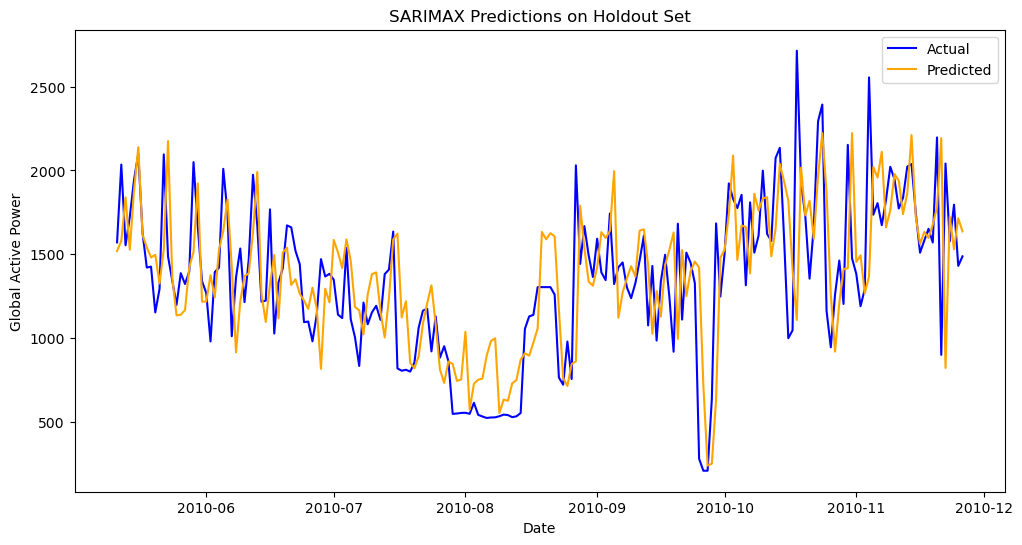

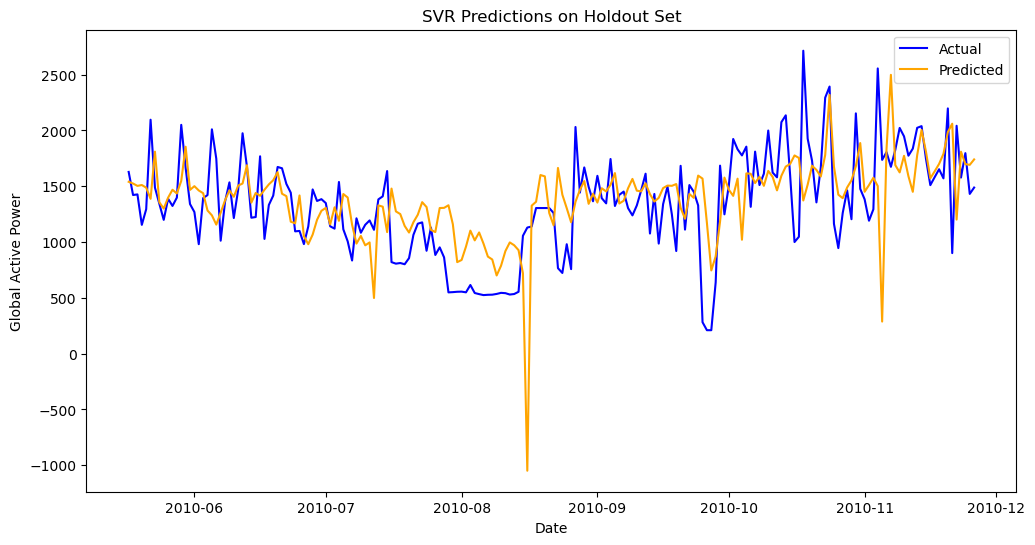

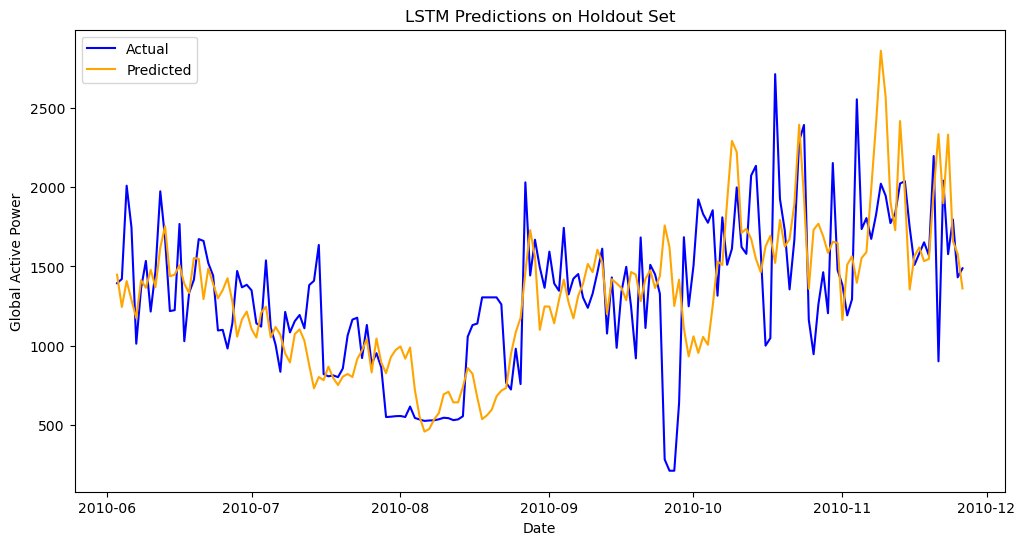

In [96]:
# Block 9: Train Best Models and Evaluate on Holdout Set

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import StandardScaler

# Assuming 'daily_data' and 'results_df' are already defined from previous blocks

# Before this code, we assume `daily_data` is a DataFrame that includes:
# 'Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
# 'non_submetered', 'AvgTemperature', 'Precipitation', 'DayCount', 'DayOfWeek', etc.
# as well as 'Global_reactive_power', 'Voltage', 'Global_intensity', 'tsun'
# which we intend to drop.

# Define the target variable
y = daily_data['Global_active_power']

# Define the full feature set
X = daily_data.drop(['Global_active_power'], axis=1)

# Drop columns with high correlation to Global_active_power
X = X.drop(['Global_reactive_power', 'Voltage', 'Global_intensity', 'tsun'], axis=1)

# Apply a one-day lag to the submetered variables so that at time t,
# the model sees values from t-1 (yesterday's values).
# This prevents trivial reverse-engineering of the target from today's submeter values.
X['Sub_metering_1'] = X['Sub_metering_1'].shift(1)
X['Sub_metering_2'] = X['Sub_metering_2'].shift(1)
X['Sub_metering_3'] = X['Sub_metering_3'].shift(1)
X['non_submetered'] = X['non_submetered'].shift(1)

# After shifting, the first row (and possibly others) become NaN because
# we don't have 'yesterday's' data for the earliest day.
# Drop these NaN rows.
X = X.dropna()

# Align y with the updated X index
y = y.loc[X.index]

# Now that the data is lagged and cleaned, we split into train and holdout sets.
# Remove the last 200 days for the independent holdout/test set
X_train_full = X.iloc[:-200]
y_train_full = y.iloc[:-200]

X_holdout = X.iloc[-200:]  # Independent test/holdout set (final 200 days)
y_holdout = y.iloc[-200:]

# Scale the training and holdout data
scaler_X = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train_full), columns=X_train_full.columns, index=X_train_full.index)
X_holdout_scaled = pd.DataFrame(scaler_X.transform(X_holdout), columns=X_holdout.columns, index=X_holdout.index)

scaler_y = StandardScaler()
y_train_scaled = pd.Series(scaler_y.fit_transform(y_train_full.values.reshape(-1, 1)).flatten(), index=y_train_full.index, name='Global_active_power')
y_holdout_scaled = pd.Series(scaler_y.transform(y_holdout.values.reshape(-1, 1)).flatten(), index=y_holdout.index, name='Global_active_power')

# Function to convert frozensets back to dictionaries and evaluate string literals
def convert_params(params_frozenset):
    params_dict = dict(params_frozenset)
    for key in params_dict:
        try:
            params_dict[key] = ast.literal_eval(params_dict[key])
        except (ValueError, SyntaxError):
            pass
    return params_dict

# Prepare results_df by extracting metrics
results_df['MAE'] = results_df['Metrics'].apply(lambda x: x['MAE'])
results_df['RMSE'] = results_df['Metrics'].apply(lambda x: x['RMSE'])
results_df['MAPE'] = results_df['Metrics'].apply(lambda x: x['MAPE'])
results_df['AIC'] = results_df['Metrics'].apply(lambda x: x.get('AIC', np.nan))
results_df['Durbin_Watson'] = results_df['Metrics'].apply(lambda x: x.get('Durbin_Watson', np.nan))

# Group results by Model and Params to compute average metrics across folds
grouped_results = results_df.groupby(['Model', 'Params', 'Lag_Binary']).agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'MAPE': 'mean'
}).reset_index()

# Retrieve the best configurations for each model family
best_sarimax_result = grouped_results[grouped_results['Model'] == 'SARIMAX'].sort_values('MAE').iloc[0]
best_svr_result = grouped_results[grouped_results['Model'] == 'SVR'].sort_values('MAE').iloc[0]
best_lstm_result = grouped_results[grouped_results['Model'] == 'LSTM'].sort_values('MAE').iloc[0]

# Convert Params back to dictionaries
best_sarimax_params = convert_params(best_sarimax_result['Params'])
best_svr_params = convert_params(best_svr_result['Params'])
best_lstm_params = convert_params(best_lstm_result['Params'])

# For SVR, get 'lag_binary' from best result
best_svr_lag_binary = best_svr_result['Lag_Binary']

# For SARIMAX and LSTM, we can set 'lag_binary' to '00000000' if needed
best_sarimax_lag_binary = '00000000'
best_lstm_lag_binary = '00000000'

# Convert parameter values to appropriate types
# For SARIMAX
best_sarimax_params['order'] = tuple(best_sarimax_params['order'])
best_sarimax_params['seasonal_order'] = tuple(best_sarimax_params['seasonal_order'])

# For SVR
best_svr_params['C'] = float(best_svr_params['C'])
best_svr_params['epsilon'] = float(best_svr_params['epsilon'])
best_svr_params['kernel'] = str(best_svr_params['kernel'])
best_svr_params['lag_binary'] = best_svr_lag_binary  # Include 'lag_binary' in params

# For LSTM
best_lstm_params['hidden_size'] = int(best_lstm_params['hidden_size'])
best_lstm_params['num_layers'] = int(best_lstm_params['num_layers'])
best_lstm_params['sequence_length'] = int(best_lstm_params['sequence_length'])
# Assuming we are not using lag features for LSTM
best_lstm_params['lag_binary'] = best_lstm_lag_binary  # Set 'lag_binary' to '00000000'
best_lstm_params['dropout'] = float(best_lstm_params['dropout'])
best_lstm_params['learning_rate'] = float(best_lstm_params['learning_rate'])

# Train and evaluate SARIMAX
print("\nEvaluating SARIMAX on holdout set...")
sarimax_results = train_sarimax(
    y_train_scaled, y_holdout_scaled, X_train_scaled, X_holdout_scaled, [best_sarimax_params], scaler_y, scaler_X
)
sarimax_metrics = sarimax_results[0]['Metrics']
print(f"SARIMAX Metrics: {sarimax_metrics}")

# Train and evaluate SVR
print("\nEvaluating SVR on holdout set...")
svr_results = train_svr(
    y_train_scaled, y_holdout_scaled, X_train_scaled, X_holdout_scaled, [best_svr_params], scaler_y
)
svr_metrics = svr_results[0]['Metrics']
print(f"SVR Metrics: {svr_metrics}")

# Train and evaluate LSTM
print("\nEvaluating LSTM on holdout set...")
lstm_results = train_lstm(
    y_train_scaled, y_holdout_scaled, X_train_scaled, X_holdout_scaled, [best_lstm_params], scaler_y
)
lstm_metrics = lstm_results[0]['Metrics']
print(f"LSTM Metrics: {lstm_metrics}")

# Helper function for plotting predictions
def plot_predictions(y_true, y_pred, model_name, offset=0):
    """
    Plots actual vs. predicted values with proper alignment.
    
    Parameters:
    - y_true: Actual unscaled true values (Series)
    - y_pred: Predicted values (already inverse-transformed, numpy array)
    - model_name: Name of the model being evaluated
    - offset: Number of initial observations to skip in y_true to align with y_pred (e.g., due to lag or sequence length)
    """
    y_true_aligned = y_true.iloc[offset:offset+len(y_pred)].copy()
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_true_aligned.index, y_true_aligned.values, label='Actual', color='blue')
    plt.plot(y_true_aligned.index, y_pred, label='Predicted', color='orange')
    plt.title(f'{model_name} Predictions on Holdout Set')
    plt.xlabel('Date')
    plt.ylabel('Global Active Power')
    plt.legend()
    plt.show()

# Generate predictions for holdout set
print("\nGenerating plots for holdout predictions...")

# SARIMAX
sarimax_predictions = sarimax_results[0]['y_pred']
plot_predictions(y_holdout, sarimax_predictions, "SARIMAX")

# SVR
svr_predictions = svr_results[0]['y_pred']
# Calculate offset due to lag features
lag_binary = best_svr_params['lag_binary']
lag_order = max([i+1 for i, bit in enumerate(lag_binary) if bit == '1']) if '1' in lag_binary else 0
svr_offset = lag_order  # Number of initial observations to skip
plot_predictions(y_holdout, svr_predictions, "SVR", offset=svr_offset)

# LSTM
lstm_predictions = lstm_results[0]['y_pred']
sequence_length = best_lstm_params['sequence_length']
lstm_offset = sequence_length  # Number of initial observations to skip
plot_predictions(y_holdout, lstm_predictions, "LSTM", offset=lstm_offset)


In [97]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)
X_train_scaled_df.columns

Index(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'non_submetered',
       'DayCount', 'DayOfWeek', 'IsWeekend', 'Month', 'AvgTemperature',
       'MinTemperature', 'MaxTemperature', 'Precipitation'],
      dtype='object')

In [98]:
print(daily_data)
print(best_svr_params)
print(best_lstm_params)
print(best_sarimax_params)

            Global_active_power  Global_reactive_power    Voltage  \
Date                                                                
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   
...                         ...                    ...        ...   
2010-11-22             2041.536                142.354  345883.85   
2010-11-23             1577.536                137.450  346428.76   
2010-11-24             1796.248                132.460  345644.59   
2010-11-25             1431.164                116.128  347812.21   
2010-11-26             1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Date                  

## Results and Insights

After applying our nested cross-validation approach with multiple feature subsets, lagged variables, and various models (SVR, SARIMAX, and LSTM), we derived several key insights:

1. **Model Performance and Ranking:**  
   Among the three primary models tested—Support Vector Regression (SVR), SARIMAX, and LSTM—the SVR model emerged as the top performer on average. This assessment is based primarily on the mean absolute error (MAE), where SVR consistently outperformed the other two models during cross-validation. SARIMAX also provided competitive results, and LSTM showed promising capabilities, though it did not surpass SVR in the majority of folds.

2. **Impact of Lagging Submetered Variables:**  
   Initially, we observed a form of output leakage: the target (Global Active Power) could be almost trivially reconstructed from today’s submetering values. This led to severe overfitting, with models performing unrealistically well during testing. By introducing a one-day lag to the submetered variables—using “yesterday’s” submeter readings to predict “today’s” Global Active Power—we mitigated this leakage. Post-lagging, the models reported more realistic error values, such as MAEs around 260 for SVR and around 305 for SARIMAX, indicating more genuine predictive performance.

3. **Comparison of Models and Metrics:**  
   - **SVR:** Achieved the best overall MAE during cross-validation and showed robustness in capturing daily consumption patterns once lagging was introduced.
   - **SARIMAX:** Performed well, especially on the holdout set, and captured seasonal and trend components effectively. With careful tuning of seasonality parameters, SARIMAX often produced a stable forecast that tracked the consumption pattern closely.
   - **LSTM:** While LSTMs are adept at detecting complex patterns, their benefit here was less pronounced. Energy consumption data does not present a simple, repetitive pattern that LSTM architectures can readily exploit. Nevertheless, after some hyperparameter tuning guided by the cross-validation results, the LSTM’s predictions improved, better matching observed peaks and valleys.

4. **Seasonality and Trend Considerations:**  
   SARIMAX’s seasonal parameters, kept as hyperparameters, were crucial. Empirical tests to identify suitable seasonal periods helped. Models like SARIMA without proper seasonal handling or lagging performed poorly, reinforcing that seasonality and correct data transformations are essential for time series forecasting in this domain.

5. **Insights from the UCI Single Household Electricity Data:**  
   This UCI dataset represents a single household’s electric power consumption. The complexity and variability in daily usage patterns make long-term patterns elusive. Our results confirm that:
   - Simple models like SARIMA struggle without proper seasonal or lag adjustments.
   - Non-linear models like SVR can adapt well if the data is presented with lagged features to avoid trivial solutions.
   - Neural approaches like LSTM might not necessarily outperform simpler models unless clear recurring patterns or longer training durations reveal more complex dependencies.

6. **Practical Implications:**  
   The results underscore the importance of carefully engineered features (like lagging submetering data) and thoughtful model selection. While sophisticated models (e.g., LSTM) can be alluring, simpler methods (SVR or SARIMAX), combined with appropriate data transformations and feature engineering, may yield better or at least comparable performance for single-household energy consumption forecasting.

In summary, by implementing a nested cross-validation framework, applying lags to prevent output leakage, and exploring multiple model families, we arrived at a more realistic and robust forecasting capability. Our findings highlight that careful data preprocessing and model evaluation are often more impactful than model complexity alone.


## Conclusion

In exploring the complex domain of household electricity consumption forecasting, we have integrated a range of analytical strategies— from advanced data preprocessing and anomaly detection with Prophet, to lagging submetered inputs to reduce trivial data leakage, to testing multiple feature subsets and model families (SARIMAX, SVR, and LSTM) under a rigorous nested cross-validation framework. Through these layers of transformation and evaluation, we found that carefully engineered features and appropriate lagging of key variables significantly improved model realism and predictive reliability. While initially susceptible to overfitting, our models, once adjusted to respect temporal dependencies and rid of trivial shortcuts, produced stable and interpretable outcomes.

The results highlight that simpler, kernel-based methods like SVR can excel in a setting where time series patterns are neither strongly seasonal nor easily discernible, outperforming even deep neural networks that typically thrive on rich, repetitive patterns. SARIMAX, too, displayed strong performance and interpretability, offering meaningful insights into underlying trends and seasonality when properly tuned. LSTM, though not the top performer here, remains a valuable tool for more complex or longer-horizon scenarios, and with additional fine-tuning and data, could uncover subtler patterns.

Ultimately, our work emphasizes that no single modeling technique universally dominates. Rather, robust forecasting solutions emerge from a thoughtful balance: judicious feature selection, appropriate transformations (like lagging and anomaly imputation), systematic hyperparameter search, and a willingness to combine descriptive, predictive, and prescriptive analytics. By adopting these principles, we not only advance our understanding of the data at hand but also equip future energy forecasting efforts with a robust, adaptable blueprint for tackling similarly intricate time series challenges.


### Emperical Tests to find Seasonality values for SARIMAX

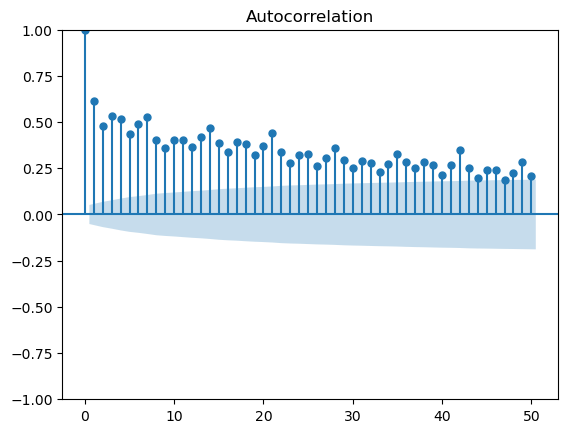

Detected seasonal lags: [ 3  7 10 14 17 21 25 28 31 35 38 42 46 49]


In [99]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import find_peaks
import statsmodels.api as sm


def detect_seasonality(y, max_lag=50):
    # Plot and compute ACF
    plot_acf(y, lags=max_lag)
    plt.show()
    
    # Get ACF values
    acf_values = sm.tsa.acf(y, nlags=max_lag)
    
    # Detect peaks in ACF
    peaks, _ = find_peaks(acf_values, height=0.1)  # Adjust height threshold as needed
    
    print(f"Detected seasonal lags: {peaks}")
    return peaks

# Example usage
seasonal_lags = detect_seasonality(y)


Suggested d: 0, Suggested D: 0


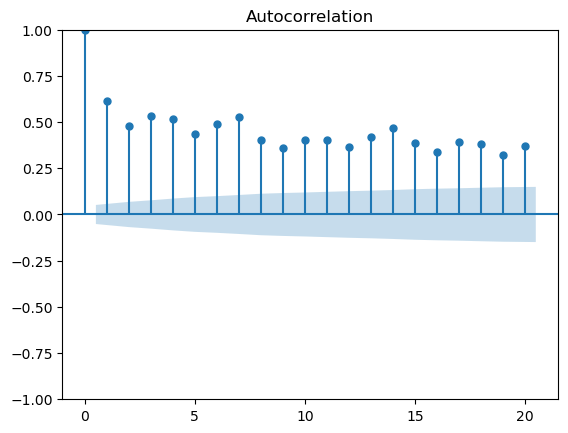

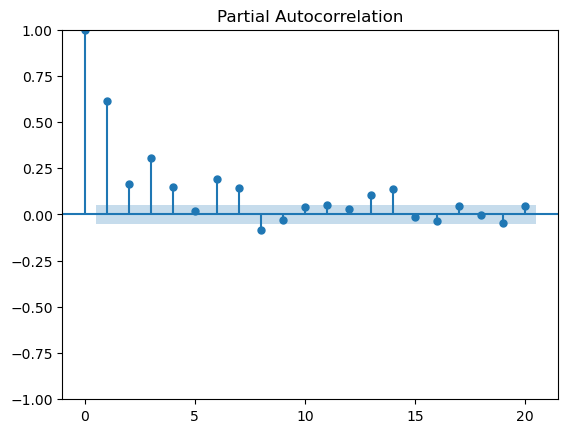

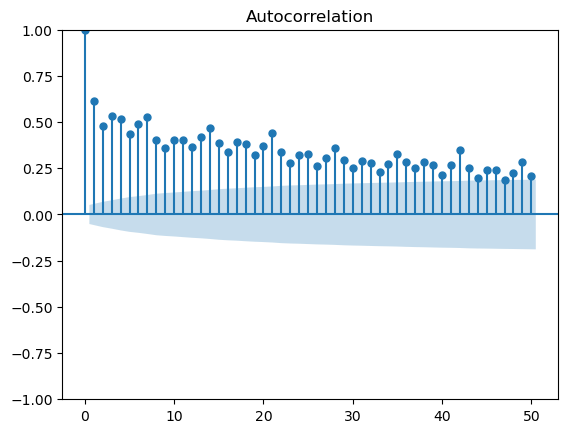

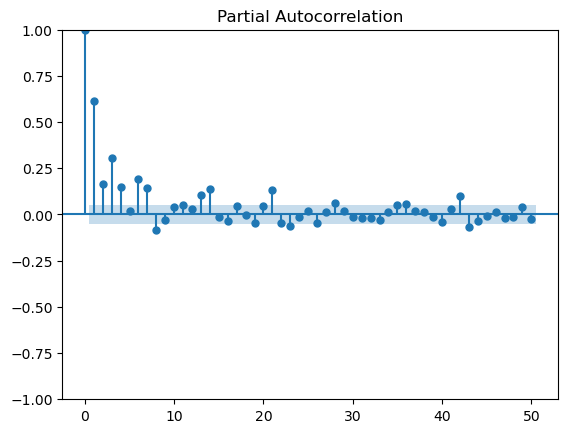

In [100]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
def suggest_sarimax_params(y, S=7):
    # Test for non-seasonal differencing
    adf_result = adfuller(y)
    d = 0 if adf_result[1] < 0.05 else 1

    # Test for seasonal differencing
    y_seasonal_diff = y.diff(S).dropna()
    seasonal_adf_result = adfuller(y_seasonal_diff)
    D = 0 if seasonal_adf_result[1] < 0.05 else 1

    # Suggest p, q, P, Q based on ACF/PACF plots
    plot_acf(y, lags=20)
    plot_pacf(y, lags=20)

    plot_acf(y, lags=50)
    plot_pacf(y, lags=50)

    print(f"Suggested d: {d}, Suggested D: {D}")

suggest_sarimax_params(y,14)

In [101]:
## SARIMA (no exogenous variables)
def train_sarima(y_train, y_test, param_list):
    """
    Train and evaluate SARIMAX for given parameters.

    Parameters:
    - y_train, y_test: Target variables for train and test sets (pd.Series)
    - param_list: List of SARIMAX hyperparameter dictionaries

    Returns:
    - List of metrics dictionaries for each hyperparameter configuration
    """
    metrics_list = []
    for params in param_list:
        try:
            # Extract parameters
            order = params['order']
            seasonal_order = params['seasonal_order']
            lag_binary = '00000000'  # No lag features for SARIMAX

            # Unscale the target variables
            #y_train_unscaled = scaler_y.inverse_transform(y_train.values.reshape(-1, 1)).flatten()
            #y_test_unscaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

            # Unscale the exogenous variables
            #X_train_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_train), 
            #                                columns=X_train.columns, 
            #                                index=X_train.index)
            #X_test_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_test), 
            #                               columns=X_test.columns, 
            #                               index=X_test.index)

            # Fit SARIMAX model
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            model_fit = model.fit(disp=False)

            # Forecast
            y_pred = model_fit.forecast(steps=len(y_test))

            # Evaluate
            metrics = evaluate_model(y_test, y_pred, model_fit)
            metrics_list.append({
                'Params': params,
                'Metrics': metrics,
                'y_pred': y_pred,
                'Lag_Binary': lag_binary  # Indicate no lag features
            })

        except Exception as e:
            print(f"Error training SARIMAX: {e}")

    return metrics_list


In [102]:
param_list

[{'dropout': 0.2872700594236812,
  'hidden_size': 124,
  'learning_rate': 0.0015255793090045732,
  'num_layers': 1,
  'sequence_length': 27},
 {'dropout': 0.17800932022121826,
  'hidden_size': 242,
  'learning_rate': 0.0012588527002965473,
  'num_layers': 3,
  'sequence_length': 27},
 {'dropout': 0.40055750587160444,
  'hidden_size': 183,
  'learning_rate': 0.004475983459259062,
  'num_layers': 1,
  'sequence_length': 8},
 {'dropout': 0.4609993861334124,
  'hidden_size': 189,
  'learning_rate': 0.001630568734622147,
  'num_layers': 1,
  'sequence_length': 7},
 {'dropout': 0.25212112147976884,
  'hidden_size': 53,
  'learning_rate': 0.0010164038588691211,
  'num_layers': 1,
  'sequence_length': 23}]

Suggested d: 0, Suggested D: 0


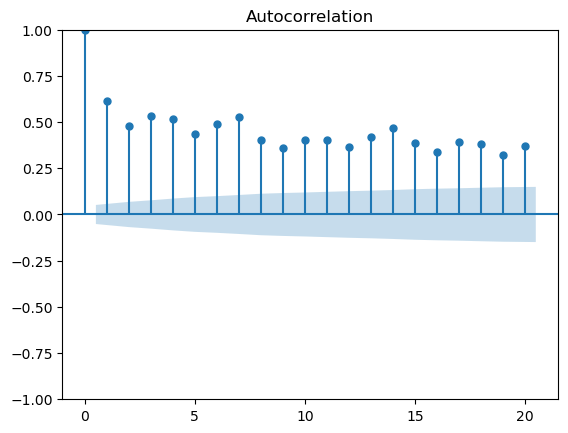

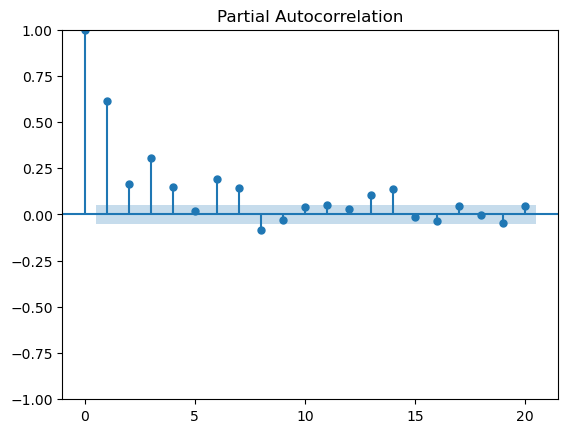

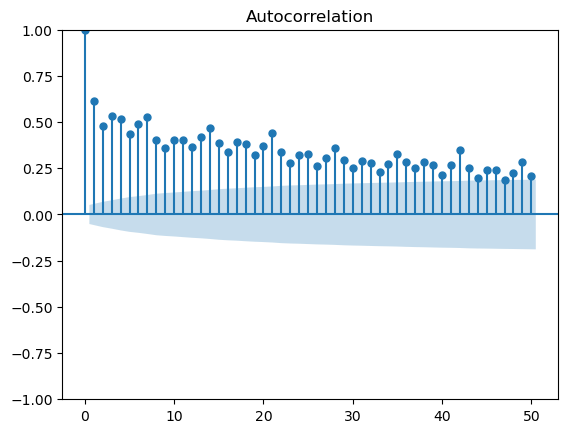

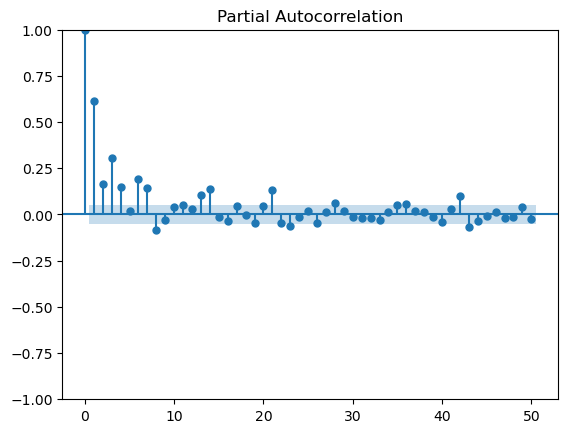

In [108]:
y_all = daily_data['Global_active_power']
y = y.loc[X.index]

# Now that the data is lagged and cleaned, we split into train and holdout sets.
# Remove the last 200 days for the independent holdout/test set
y_train_full = y.iloc[:-200]
y_holdout = y.iloc[-200:]
suggest_sarimax_params(y,7)
sarima_params = {'order': (2, 0, 3), 'seasonal_order': (1, 0, 1, 14)}  # Example params


sarima_results = train_sarima(y_train_full, y_holdout, [sarima_params])

In [110]:
print(sarima_results)

[{'Params': {'order': (2, 0, 3), 'seasonal_order': (1, 0, 1, 14)}, 'Metrics': {'MAE': 502.4595219687892, 'RMSE': 641.9060784005954, 'MAPE': 40.50046863401445, 'AIC': 18294.3903864623, 'Durbin_Watson': 0.37676318432587}, 'y_pred': 2010-05-11    1445.963987
2010-05-12    1472.609608
2010-05-13    1439.468957
2010-05-14    1406.733900
2010-05-15    1453.492178
                 ...     
2010-11-22     631.200058
2010-11-23     640.098222
2010-11-24     646.848264
2010-11-25     634.870824
2010-11-26     623.319974
Freq: D, Name: predicted_mean, Length: 200, dtype: float64, 'Lag_Binary': '00000000'}]


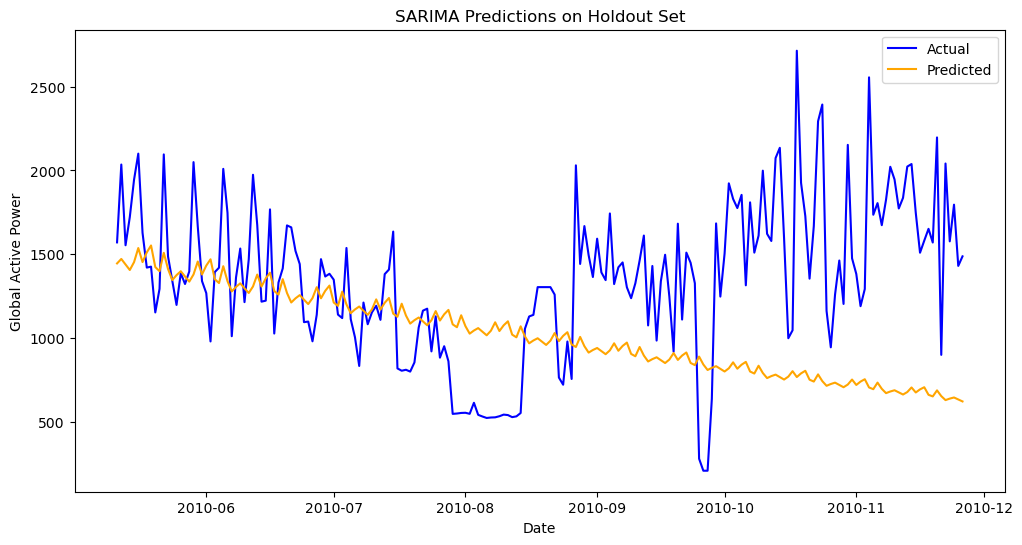

In [109]:
sarima_predictions = sarima_results[0]['y_pred']
plot_predictions(y_holdout, sarima_predictions, "SARIMA")

## References

1. Taylor, S.J. and Letham, B. (2018). "Forecasting at Scale." *The American Statistician*, 72(1): 37-45.  
   This paper introduces the Facebook Prophet framework, which we utilized for anomaly detection and imputing anomalous values in the target variable.

2. Hyndman, R.J. and Athanasopoulos, G. (2018). *Forecasting: Principles and Practice* (2nd ed). OTexts.  
   Available online at <https://otexts.com/fpp2/>.  
   This resource provides extensive coverage of time series forecasting methods, including ARIMA and SARIMA models, guiding our understanding of seasonal parameters and model diagnostics.

3. Fan, S., Xiao, F., Zhao, Y. (2017). "A short-term building cooling load forecasting method using deep learning algorithms." *Applied Energy*, 195: 222-233.  
   Although focused on cooling load, this paper exemplifies the use of LSTM networks for energy-related forecasting tasks, offering insights into neural network architectures for time series.

4. Cadenas, E., Rivera, W., Cadenas, R. (2016). "Wind speed forecasting using SARIMA models in the Veracruz region, Mexico." *Renewable Energy*, 85: 790-809.  
   While this study addresses wind speed rather than household consumption, it demonstrates the effectiveness of SARIMA/SARIMAX approaches in capturing seasonal patterns in complex time series, informing our approach to using seasonal parameters in SARIMAX.

5. Weron, R. (2014). *Electricity Price Forecasting: A Review of the State-of-the-Art with a Look into the Future.* *International Journal of Forecasting*, 30(4): 1030-1081.  
   This review discusses various forecasting techniques (including machine learning methods and time series models) in the context of energy markets, providing perspective on why methods like SVR and LSTM are considered and their relative challenges.
6. Kamuna, Amaar et al. "Machine learning based energy demand prediction." *The 8th International Conference on Sustainable and Renewable Energy Engineering*, special issue of *Energy Reports*, vol. 9, no. 12, 2023, pp. 171-176. doi:10.1016/j.egyr.2023.09.151

These references collectively assisted us in understanding best practices for anomaly detection, model selection, seasonal parameter tuning, and the application of advanced forecasting models such as LSTM and SVR in the domain of energy consumption forecasting.
